# **Kaggle Titanic Survival Competition**

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## **Table of content**

1. Exploring the Dataset
   1.  Column Identification and Count
   2.  Data Snapshot
   3.  Data Types Overview
   4.  Record Count
2. Data Cleaning
   1. Checking for duplicates
   2. Dropping columns
   3. Handling missing values
   4. Checking and converting the types
3. Defining & Answering the Questions
   1. Defining the questions
4. Building a Model
5. Testing the Model

---

## **1. Exploring the Dataset**

My primary objective is to gain a comprehensive understanding of the dataset that forms the basis of my analysis. I seek answers to the following overarching questions:

By addressing these questions, I lay the foundation for a comprehensive exploration of the dataset, enabling me to proceed with informed data analysis and manipulation.


### 1.1. Column Identification and Count

The first step involves identifying and quantifying the columns present in the dataset. I aim to determine the total number of columns, providing a foundational understanding of the dataset's structure:

In [198]:
titanic_df = pd.read_csv('./data/train.csv')

print(titanic_df.columns)
print(len(titanic_df.columns))

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
12


### 1.2. Data Snapshot

To grasp the nature of the data, I take a closer look at its content. This involves examining a snapshot of the dataset to get a sense of the actual values and how they are structured:

In [199]:
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### 1.3. Data Types Overview

Understanding the types of data present in the dataset is crucial for subsequent processing. I delve into the data types to comprehend the nature of the information:

In [200]:
print(titanic_df.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


### 1.4. Record Count

The size of the dataset, measured by the number of records it contains, is an essential factor in understanding its scope. I ascertain the total count of records to gauge the volume of data I'm working with:

In [201]:
num_entries = titanic_df.shape[0]
print("Number of records:", num_entries)

Number of records: 891


---

## **2. Data Cleaning**

In the cleaning process, I perform some data checking and manipulation tasks that will hopefully improve the usability and quality of the predictions in later steps. Each dataset is unique, so there are no overarching rules that can always be applied. It is therefore necessary to select the appropriate steps according to the dataset in question.

These possible steps include
- Checking and removing duplicate data
- Possibly dropping unnecessary columns
- Dealing with missing values
- Checking and possibly converting types
- Possibly adjusting the granularity of the data
- Find outliers and deal with them appropriately
- Feature engineering to create new features

In [202]:
# First I create a deep copy to guarantee that the original dataframe stays as it is
t_df = titanic_df.copy(deep=True)

### 2.1. Checking for duplicates

First we sort the data, then we check for duplicates. It is important to sort the data first because the `duplicated()` method only compares each row with the previous row. So if there are rows between duplicates, the duplicated() method will not catch them.

For the sort values I have chosen the **Ticket** and **Cabin** features:


In [203]:
# Checking all rows from the original DF for duplicates
t_df_sorted = t_df.sort_values(by=['Ticket', 'Cabin'])
duplicates = t_df_sorted.duplicated()
number_duplicate = duplicates.sum()
print("Number of duplicates:",number_duplicate)

Number of duplicates: 0


There do not appear to be any duplicates, so we will proceed to the next step. Please note that this is only a very rudimentary technique for checking for duplicate values. There are certainly more sophisticated methods that may be required for more critical data analysis projects.

### 2.2. Dropping columns

As each row already has an **ID** provided by the dataframe, the **PassengerID** column is redundant and can be dropped.

In [204]:
# DF with dropped PassengerId column
t_df_dropped = t_df.drop(['PassengerId'], axis=1)

### 2.3. Handling missing values

#### 2.3.1. What is missing?

The very first step is to identify where the missing values are situated. It's important to understand why the values are missing. Is there a pattern in the missing data? Is it missing completely at random, or is there a systematic reason? 


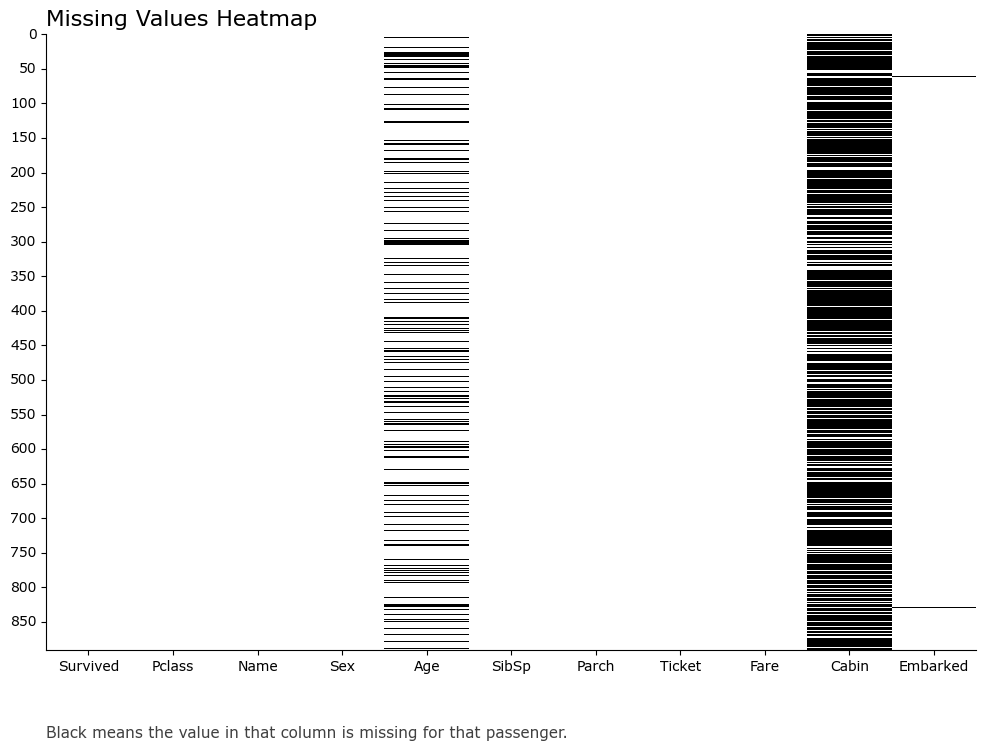

In [205]:
# Creating a heatmap of missing values
plt.rcParams['font.family'] = "Verdana"

plt.figure(figsize=(12, 8))
title = plt.title("Missing Values Heatmap", loc="left", fontname="Verdana", fontsize=16)

sns.heatmap(t_df_dropped.isnull(), cmap="binary", cbar=False, yticklabels=50)
plt.yticks(rotation=0)
sns.despine(left=False, bottom=False)

description = "Black means the value in that column is missing for that passenger."
plt.figtext(0.125, 0, description, ha="left",  fontname="Verdana", fontsize=11, color='#404040')

plt.show()


**NOTE:** Dropping all the rows with missing values results in a dataframe with only 183 rows compared to the original 891. Due to the significance of this action, this approach is not recommended.

After analysing the occurrence of missing data, it is clear that there are two main columns in question: **Age** and **Cabin**. 
Embarked also has some missing values. There are several options: 

- If a column has a high percentage of missing values and doesn't provide significant information, it can be considered for removal.
- If the missing values are limited to a small number of rows, you could consider removing those rows. However, be careful as this may result in the loss of valuable data.
- Fill the column with wildcards, for example "Unknown", rather than leaving it as NaN or null.
- Imputation, where missing values are replaced with estimated values (e.g. mean, median, mode).
- Creating multiple versions of the dataset, where missing values are imputed differently in each version. This can help to capture the uncertainty around the imputed values.

#### 2.3.2. Which of the missing values could be important?

We want to find out if there are any features that might be more important than others. We compare these features with the **Survived** feature to see if there are any potential trends. If there is evidence of trends, we may be able to prioritise working on these features and spend more time cleaning and imputing missing values for them to ensure that their quality is good after the cleaning process.

#### The Age feature

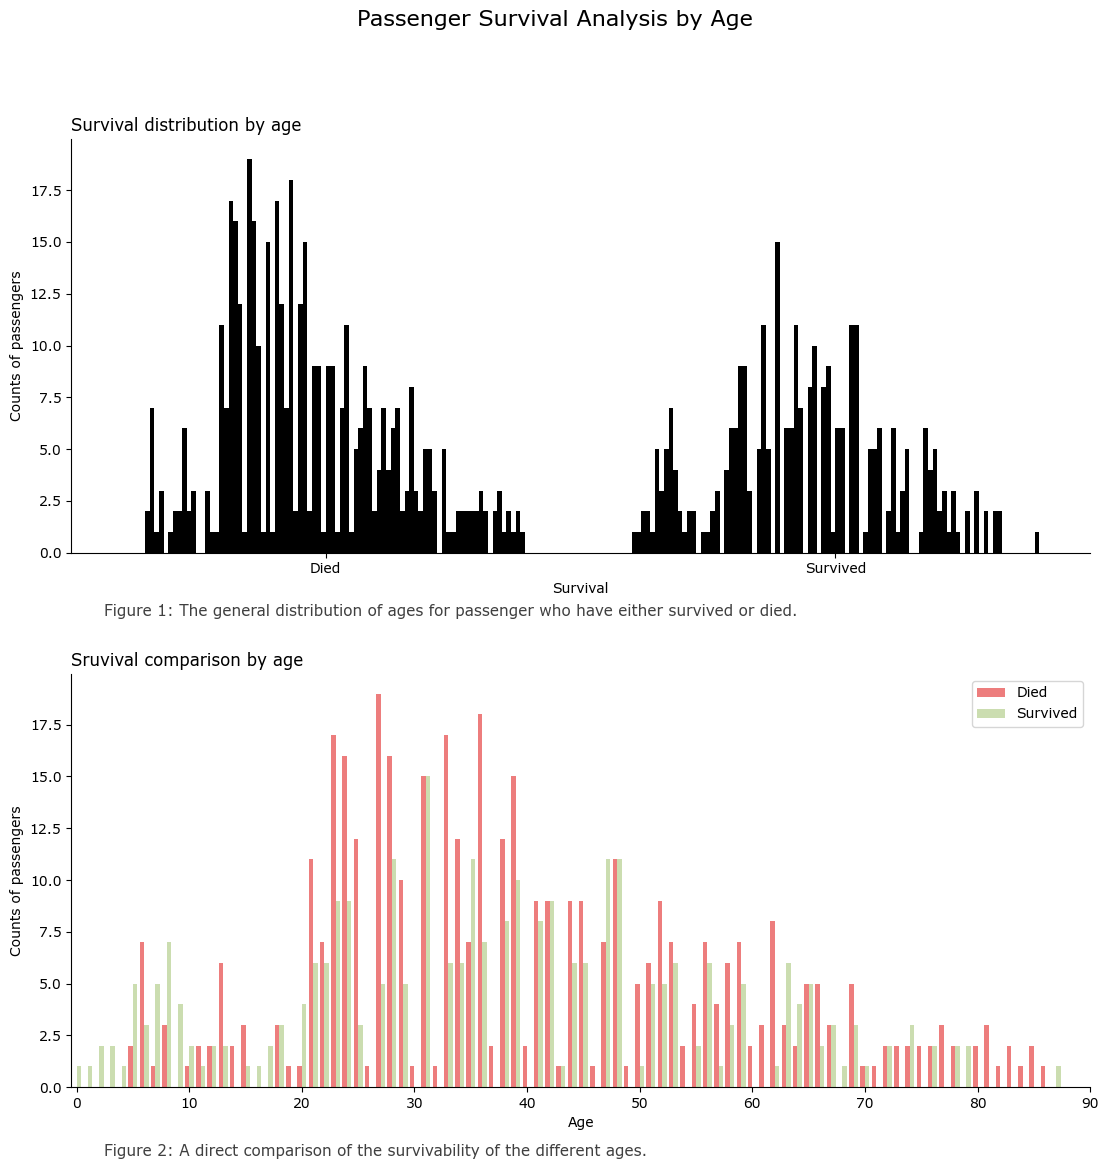

In [206]:
# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 12))  # 2 rows, 1 column

plt.rcParams['font.family'] = "Verdana"

fig.suptitle("Passenger Survival Analysis by Age", fontsize=16)

# Plot 1: Bar plot for survival vs. age
ax1 = sns.countplot(x='Survived', data=t_df_dropped, hue="Age", palette=['black'], ax=axes[0])
ax1.set_ylabel("Counts of passengers")
ax1.set_xlabel("Survival")
ax1.set_xticklabels(["Died", "Survived"])

ax1.set_title("Survival distribution by age", loc="left")
ax1.get_legend().remove()
fig.text(0.125, 0.475, "Figure 1: The general distribution of ages for passenger who have either survived or died.", ha="left", fontname="Verdana", fontsize=11, color='#404040')

# Plot 2: Bar plot for survival relative to age with significance
custom_palette = {0: "#FF6B6B", 1: "#CCE5A8"} 
ax2 = sns.countplot(x='Age', data=t_df_dropped, hue="Survived", palette=custom_palette, ax=axes[1])
ax2.set_ylabel("Counts of passengers")
ax2.set_xlabel("Age")

custom_xtick_labels = ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90']
ax2.set_xticks(range(0, len(custom_xtick_labels) * 10, 10))
ax2.set_xticklabels(custom_xtick_labels)

ax2.set_title("Sruvival comparison by age", loc="left")
custom_legend = ax2.legend(labels=["Died", "Survived"], loc="upper right")
fig.text(0.125, 0.025, "Figure 2: A direct comparison of the survivability of the different ages.", ha="left",  fontname="Verdana", fontsize=11, color='#404040')

# Remove spines and adjust layout for both subplots
for ax in axes:
    sns.despine(ax=ax, left=False, bottom=False)

plt.tight_layout(pad=4.0)

plt.show()

**Notable:**
- very young passengers seemed to do better
- Very old passengers seemed to do worse. 
- Mortality in the 20-40 age group seemed to be higher than in other age groups.

At first sight, age seems to play a role in survivability. It might as well also be a proxy for another feature, for example passengers of particular classes might be more prone to belong in a specific age range etc. 

Anyway, additional care should be taken to ensure that missing values are replaced/imputed accordingly.

#### The Cabin feature

The other feature with a lot of missing values is the cabin feature. It is highly unlikely that we are going to be able to preciously impute the matching, missing cabin numbers for all the passengers. A more sensible approach might therefore be to bin the cabins numbers into a new feature called **Deck**. We will explore this path in the following segments.

#### 2.3.3. How to deal with the missing data

One way of dealing with missing values would be to infer the data from similar entries. For example, suppose we have a passenger with a missing value for cabin:

- We could try to find out if they are married to another passenger for whom we know the cabin by checking the name.
- We could check if the class gives us a rough estimate of where the cabin would be on the ship, or at least what type of cabin it is.
- We could check the price to infer what type of cabin it might be and where it would be located.
- We could check if there are any patterns related to the *embarked* feature, i.e. if people who embarked at the same location were allocated similarly located cabins.

While this may sound sensible, it is by no means a hard and fast rule and could therefore make the model perform worse. It is therefore a good idea to split the datasets into two versions: one where all entries with missing values are removed, and one where the missing values are inferred from other features.

It is also important to think about what we are actually trying to find out and whether the data is relevant to answering those questions. For further elaboration of the questions to be answered, see the section *Definition of the questions to be answered*.

In [207]:
# Creating a deep copy of the previous dataframe
df_clean = t_df_dropped.copy(deep=True)

##### *Embarked*

Since the rows with missing values are limited to a small number of rows in the *Embarked* column, I am going to remove them altogether since there is no clear way of figuring out the values. One might argue, that the *Embarked* column might not be that relevant altogether and it might be more valuable to keep the two entries and just be done with the *Embarked* column, which is a valid argument. However at the time being we will focus on one path, and might come back later to try and optimise the quality of the model.

In [208]:
# Dropping the rows with missing values in the Embarked column
df_clean = df_clean.dropna(subset=['Embarked'])

##### *Cabin*

Given that cabins are organized by class and are likely grouped together on specific decks, it could be advantageous to adjust the granularity of the dataset and introduce a "deck" feature. This feature could serve as a substitute for the potentially challenging task of pinpointing individual cabin numbers through a binning method.

We delve into this idea because the location of cabins, or the decks they are on, might play a role in the passengers' chances of survival. For instance, proximity to emergency escape routes (or emergency vessels) or distance from the waterline could be critical factors.

If classes are indeed grouped within specific decks, we can assign passengers with unknown decks based on the most probable deck associated with their class. This approach can help us piece together valuable information about passenger deck location, ultimately contributing to a more comprehensive analysis of survival factors.

To test the assumptions about the class groupings in decks, it is possible to refer to external data like the image below:

![Titanic Decks](images/White-Star-Line-Titanic-and-Olympic.png)

(Source: https://clickamericana.com/wp-content/uploads/White-Star-Line-Titanic-and-Olympic.jpg)

We can infer from the image that the following deck-class distribution holds:

- Deck A:  
  - 1st class staterooms
- Deck B: 
  - 1st class staterooms
  - 1st class suites
  - 1st class cabins
- Deck C: 
  - 1st class apartments
  - 1st class cabins de luxe
- Deck D: 
  - 2nd class staterooms
  - 3rd class rooms
- Deck E:
  - 1st class staterooms
  - 2nd class staterooms
  - 3rd class rooms
- Deck F:
  - 2nd class staterooms
  - 3rd class rooms
- Deck G:
  - 3rd class rooms

In [209]:
# Replacing the missing values with 'Unknown' so that they do not contain NaN or null
df_clean.loc[df_clean['Cabin'].isnull(), 'Cabin'] = 'Unknown'

We can create a Deck feature from the Cabin values. The cabin number always starts with a designation letter of the deck. We can slice this character off and insert it into our newly created Deck column.

In [210]:
# Creating a deck column with the first letter of the cabin
df_clean.loc[:, 'Deck'] = df_clean['Cabin'].apply(lambda cabin: cabin[0])

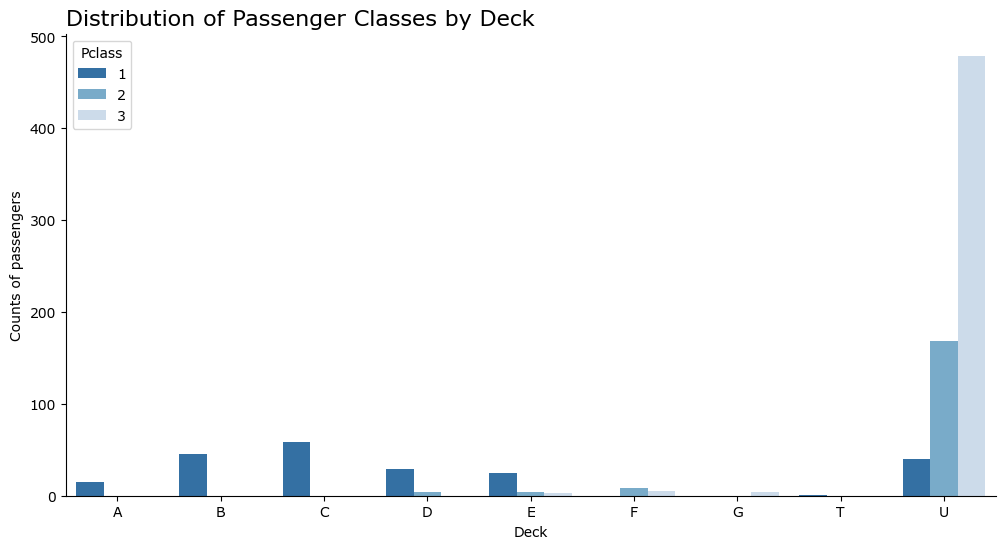

In [211]:
# Creating a categorical plot
plt.rcParams['font.family'] = "Verdana"
plt.figure(figsize=(12, 6))

plt.title("Distribution of Passenger Classes by Deck", loc="left", font="Verdana", fontsize=16)


ax = sns.countplot(x='Deck', data=df_clean, hue='Pclass', palette="Blues_r", order=sorted(df_clean['Deck'].unique()))
ax.set_ylabel("Counts of passengers")

sns.despine(left=False, bottom=False)

plt.show()

As we can see the U (Unknown) deck takes up the vast majority of the passengers, which makes sense, since it is tied to the **Cabin** feature, which has a lot of missing values. We can remove the U deck so that it does not skew up our graph too much.

In [212]:
filtered_df = df_clean[df_clean['Deck'] != 'U']

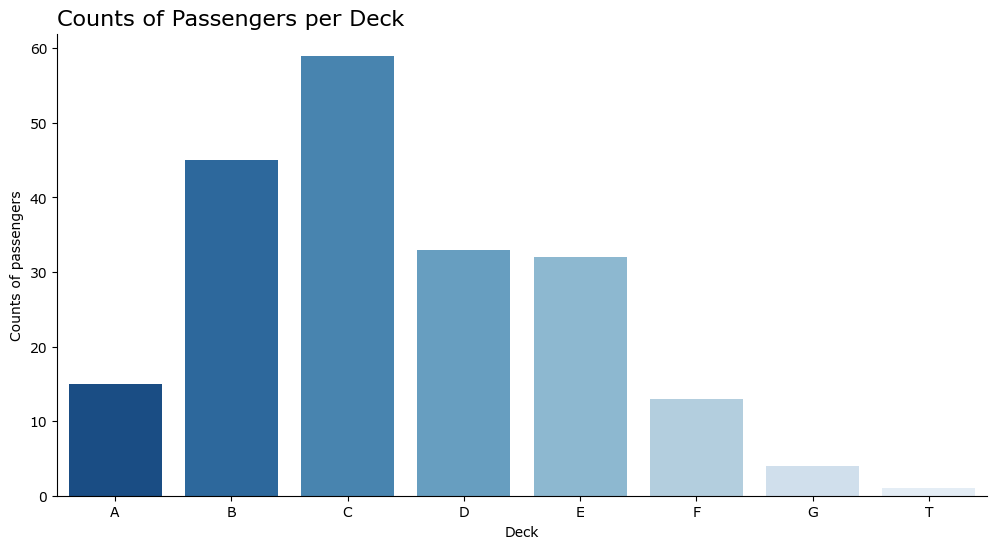

In [213]:
# Creating a categorical plot
plt.rcParams['font.family'] = "Verdana"
plt.figure(figsize=(12, 6))

plt.title("Counts of Passengers per Deck", loc="left", font="Verdana", fontsize=16)

ax = sns.countplot(x='Deck', data=filtered_df, palette="Blues_r", order=sorted(filtered_df['Deck'].unique()))
ax.set_ylabel("Counts of passengers")

sns.despine(left=False, bottom=False)

plt.show()

Now we could try to find out if there are particular classes that belong to decks. This would possibly allow us to infer the missing deck value for passenger for whom we know the class, but not the deck. To do this, let us first visualize the distribution of classes per deck and see if we can learn something from the data.

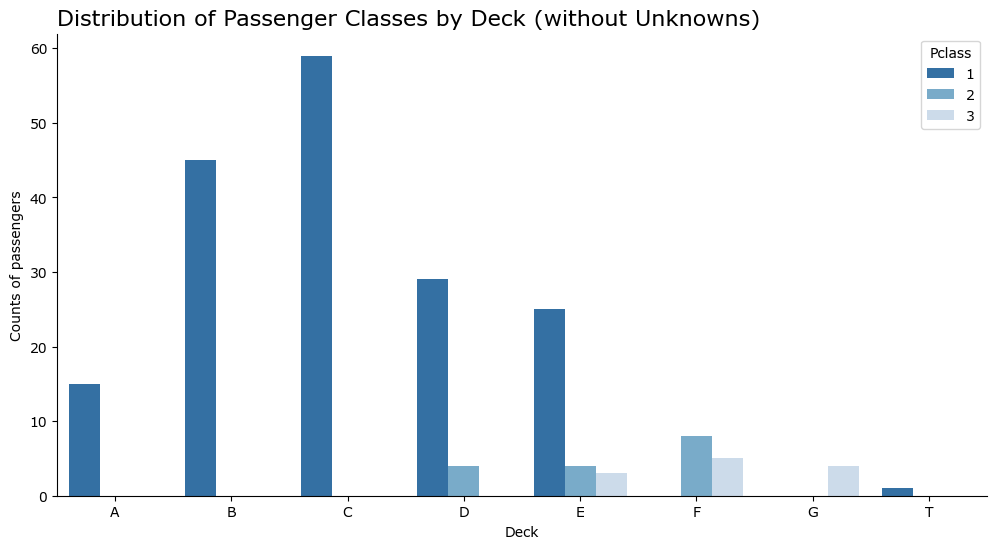

In [214]:
# Creating a categorical plot
plt.rcParams['font.family'] = "Verdana"
plt.figure(figsize=(12, 6))

plt.title("Distribution of Passenger Classes by Deck (without Unknowns)", loc="left", font="Verdana", fontsize=16)

ax = sns.countplot(x='Deck', data=filtered_df, hue='Pclass', palette="Blues_r", order=sorted(filtered_df['Deck'].unique()))
ax.set_ylabel("Counts of passengers")

sns.despine(left=False, bottom=False)

plt.show()

Initial findings just based on visual analysis

- Deck A only 1st class passengers
- Deck B only 1st class passengers
- Deck C only 1st class passengers
- Deck D first mixed passengers class deck
- Deck E all classes
- Deck F only 2nd and 3rd class passengers
- Deck G almost exclusively 3rd class passengers
- Deck T only first class passengers (likely special deck)

Another intersting insight would be to know what the mortality rate looks like per deck. 

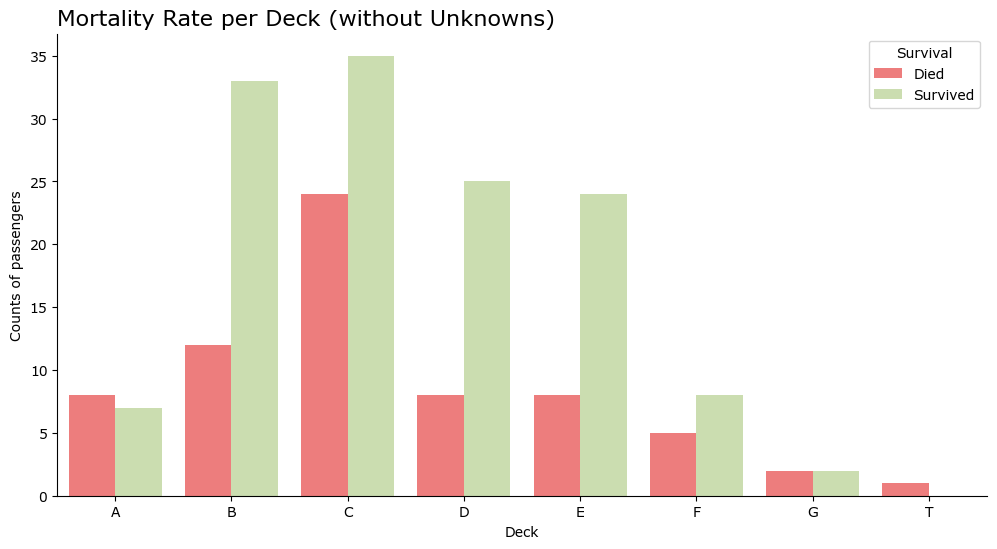

In [215]:
# Creating a categorical plot
plt.rcParams['font.family'] = "Verdana"
plt.figure(figsize=(12, 6))
custom_palette = {0: "#FF6B6B", 1: "#CCE5A8"} 

plt.title("Mortality Rate per Deck (without Unknowns)", loc="left", font="Verdana", fontsize=16)
ax2 = sns.countplot(x='Deck', data=filtered_df, hue='Survived', palette=custom_palette, order=sorted(filtered_df['Deck'].unique()))
ax2.set_ylabel("Counts of passengers")
ax2.legend(title="Survival",labels=["Died", "Survived"])
sns.despine(left=False, bottom=False)

plt.show()

##### *Parent/ Children (Parch)*

Although the Parch values are not missing, it might be worthwhile to adapt the granularity of the **Parch** feature to further extract more granular information about the passengers on board and make better predictions.

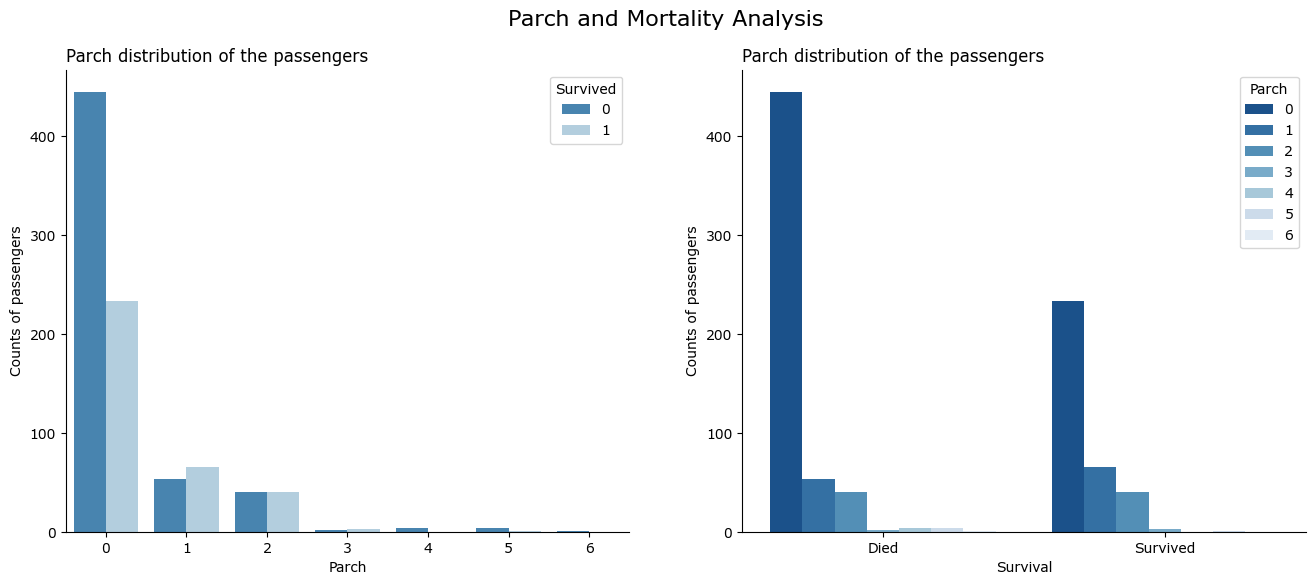

In [216]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

plt.rcParams['font.family'] = "Verdana"

fig.suptitle("Parch and Mortality Analysis", fontsize=16)

# Plot 1
ax1 = sns.countplot(x='Parch',data=t_df_dropped, hue="Survived",palette="Blues_r", ax=axes[0])
ax1.set_ylabel("Counts of passengers")
ax1.set_title("Parch distribution of the passengers", loc="left")

sns.despine(left=False, bottom=False, ax=ax1)

# Plot 2
ax2 = sns.countplot(x='Survived',data=t_df_dropped, hue="Parch",palette="Blues_r", ax=axes[1])
ax2.set_ylabel("Counts of passengers")
ax2.set_xlabel("Survival")
ax2.set_xticklabels(["Died", "Survived"])
ax2.set_title("Parch distribution of the passengers", loc="left")

sns.despine(left=False, bottom=False, ax=ax2)

plt.show()

##### *Age*

Since the age plays a vital role in survivability in general, it makes sense to spend a little bit more time on trying to fill in the gaps. 

**Using the Title as an indicator**
- Splitting the name to first name, last name and title and plotting the age distribution of the various titles to find patterns.
- Age binning (age ranges) instead of specific values, to get generalized plots.
- Imputation of the age via similarly titled people and using the median age of that group as value.
  - Using Bayes Theorem to estimate missing ages based on titles.



**Using other methods/ features**
- Using the parch feature to find out if it is a child or a parent.
- External datasets of historical and demographic datasets that could potentially provide insights into age distributions during that time period regarding the titles.
- Using plot to find out if there are patterns regarding the age and class features.

Comparing the results of the different methods to gauge the degree of uncertainty.

In [217]:
age_cleaning = df_clean.copy(deep=True)

First, let us adapt the granularity of the **Name** feature and split it into "Last Name," "Title," and "First Name".

In [218]:
# Splitting the "Name" feature into "Last Name," "Title," and "First Name"
name_split = age_cleaning['Name'].str.split(',', n=1, expand=True)
age_cleaning.loc[:, 'Last Name'] = name_split[0].str.strip()
age_cleaning.loc[:, 'Rest'] = name_split[1]

title_split = age_cleaning['Rest'].str.split('.', n=1, expand=True)
age_cleaning.loc[:, 'Title'] = title_split[0].str.strip()
age_cleaning.loc[:, 'First Name'] = title_split[1].str.strip()

# Removing extra whitespace from columns
age_cleaning.loc[:, 'Last Name'] = age_cleaning['Last Name'].str.strip()
age_cleaning.loc[:, 'First Name'] = age_cleaning['First Name'].str.strip()

# Dropping the "Rest" column
age_cleaning.drop(columns=['Rest'], inplace=True)


Because estimating the specific age per person is pretty difficult, an easier approach would be to define age bins/ ranges.

In [219]:
# Defining the age ranges and corresponding labels
age_ranges = [
    (0, 2, '0-2'),
    (3, 5, '3-5'),
    (6, 12, '6-12'),
    (13, 19, '13-19'),
    (20, 29, '20-29'),
    (30, 39, '30-39'),
    (40, 49, '40-49'),
    (50, 59, '50-59'),
    (60, 69, '60-69'),
    (70, 79, '70-79'),
    (80, float('inf'), '80+')
]

# Function to map age to age range label
def map_age_to_range(age):
    for start, end, label in age_ranges:
        if start <= age <= end:
            return label
    return 'Unknown'

# Creating the ARange column by applying the map_age_to_range function to the Age column
age_cleaning.loc[:,'ARange'] = df_clean['Age'].apply(lambda age: map_age_to_range(age) if pd.notnull(age) else 'Unknown')


The following heatmap plot provides a visual representation of how different titles (e.g., Mr., Mrs., Miss, etc.) are distributed across various age groups. This can help understand the demographics of passengers on the Titanic more clearly.

By using a heatmap, one can quickly identify possible patterns and trends in the age distribution of passengers based on their titles. This can be valuable for exploring questions like, "Are certain titles associated with specific age groups?" or "How does the age distribution vary among different titles?"

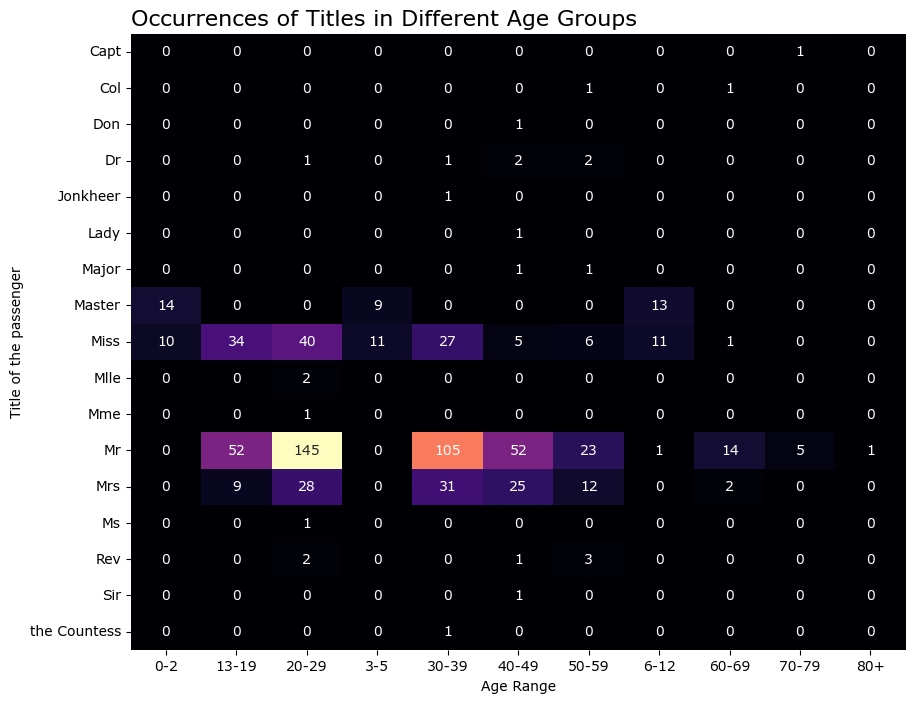

In [220]:
# Filtering out the passengers with unknown ages
filtered_df = age_cleaning[age_cleaning['ARange'] != 'Unknown']
cross_tab = pd.crosstab(age_cleaning['Title'], filtered_df['ARange'])

# Creating a plot to show the distribution of the ARange (age bins) per Title
plt.rcParams['font.family'] = "Verdana"
plt.figure(figsize=(10, 8))

sns.heatmap(cross_tab, annot=True, fmt='d', cmap='magma', cbar=False)

plt.title("Occurrences of Titles in Different Age Groups", loc="left", fontname="Verdana", fontsize=16)
plt.xlabel("Age Range")
plt.ylabel("Title of the passenger")

plt.show()

#### 2.3.4. Bayes Theorem to estimate the ages

In [221]:
df_clean_bayesian = age_cleaning.copy(deep=True)

# Function to estimate missing ages using Bayesian inference
def estimate_age(title_group):
    known_ages = title_group.dropna()
    if len(known_ages) > 0:
        age_range = known_ages.min(), known_ages.max()
        num_known_ages = len(known_ages)
        age_samples = np.random.uniform(age_range[0], age_range[1], num_known_ages)
        return age_samples.mean()
    return np.nan

# Grouping the data by titles
title_groups = df_clean_bayesian.groupby('Title')

# Estimating ages for each title group
for title, group in title_groups:
    estimated_age = estimate_age(group['Age'])
    # Replacing missing ages with estimated ages
    df_clean_bayesian.loc[group.index, 'Age'] = df_clean_bayesian.loc[group.index, 'Age'].fillna(estimated_age)

# Creating the ARange column using the updated ages
df_clean_bayesian['ARange'] = df_clean_bayesian['Age'].apply(lambda age: map_age_to_range(age) if pd.notnull(age) else 'Unknown')


#### 2.3.5. Sanity Check


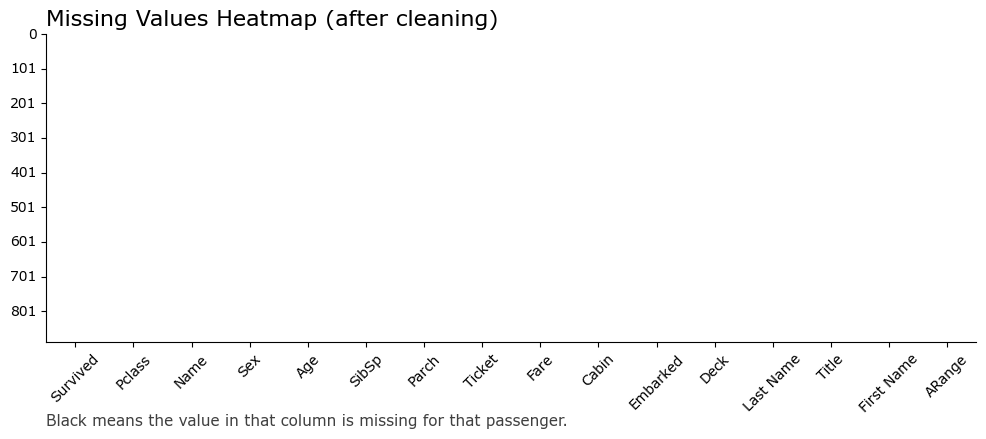

In [222]:
# Creating a heatmap of missing values to check if none are still missing
plt.rcParams['font.family'] = "Verdana"

plt.figure(figsize=(12, 4))
title = plt.title("Missing Values Heatmap (after cleaning)", loc="left", fontname="Verdana", fontsize=16)

sns.heatmap(df_clean_bayesian.isnull(), cmap="binary", cbar=False, yticklabels=100)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
sns.despine(left=False, bottom=False)

description = "Black means the value in that column is missing for that passenger."
plt.figtext(0.125, -0.1, description, ha="left",  fontname="Verdana", fontsize=11, color='#404040')

plt.show()

### 2.4. Checking and converting the types

To male operations more effictient it is recommended effectively convert the types to the smallest possible data types. For example the 'Survived' feature is comprised of only 0 and 1, therefore it does not make sense for it to be an INT64 data type. A much more efficient type would be the boolean data type. 

In [223]:
converted_cleaned_df = df_clean_bayesian.copy(deep=True)

# Type conversion of DF with removed values
converted_cleaned_df['Survived'] = converted_cleaned_df['Survived'].astype('int8')
converted_cleaned_df['Pclass'] = converted_cleaned_df['Pclass'].astype('int8')
converted_cleaned_df['Name'] = converted_cleaned_df['Name'].astype('string')
converted_cleaned_df['Last Name'] = converted_cleaned_df['Last Name'].astype('string')
converted_cleaned_df['First Name'] = converted_cleaned_df['First Name'].astype('string')
converted_cleaned_df['Embarked'] = converted_cleaned_df['Embarked'].astype('string')
converted_cleaned_df['Cabin'] = converted_cleaned_df['Cabin'].astype('string')
converted_cleaned_df['Ticket'] = converted_cleaned_df['Ticket'].astype('string')
converted_cleaned_df['Title'] = converted_cleaned_df['Title'].astype('string')
converted_cleaned_df['Deck'] = converted_cleaned_df['Deck'].astype('string')
converted_cleaned_df['Sex'] = converted_cleaned_df['Sex'].astype('string')
converted_cleaned_df['Age'] = converted_cleaned_df['Age'].astype('int8')
converted_cleaned_df['SibSp'] = converted_cleaned_df['SibSp'].astype('int8')
converted_cleaned_df['Parch'] = converted_cleaned_df['Parch'].astype('int8')


print(converted_cleaned_df.dtypes)



Survived                int8
Pclass                  int8
Name          string[python]
Sex           string[python]
Age                     int8
SibSp                   int8
Parch                   int8
Ticket        string[python]
Fare                 float64
Cabin         string[python]
Embarked      string[python]
Deck          string[python]
Last Name     string[python]
Title         string[python]
First Name    string[python]
ARange                object
dtype: object


---

## **3. Defining & Answering the Questions**

The overall question is: What are the main factors that contributed to the survival rate of a passenger on the Titanic?

### 3.1. Defining the questions

To build a successful model that attempts to predict survivability, it is first necessary to find related features. To find possible features that affect survivability, I first define some assumptions that I want to test:

**1. Does class have an effect on the survivability?**

Assumption: due to the fact that higher class passengers had priority on emergency ships

**2. Does age have an effect on the survivability?** 

Assumption: due to the fitness of the individual, there could be an advantage.

**3. Does the cabin, and threfore deck, have an effect on the survivability?**

Assumption: due to proximity to exits and/ or proxy of their class.

Please note that these assumptions are completely made up and based on intuition. They are just there to give me something to work with and investigate. Even if there is a relationship between survivability and the feature, this does not necessarily mean that there is a correlation or proof of my initial assumption.

### 3.2. Trying to answer the questions

#### 3.2.1. The role of class

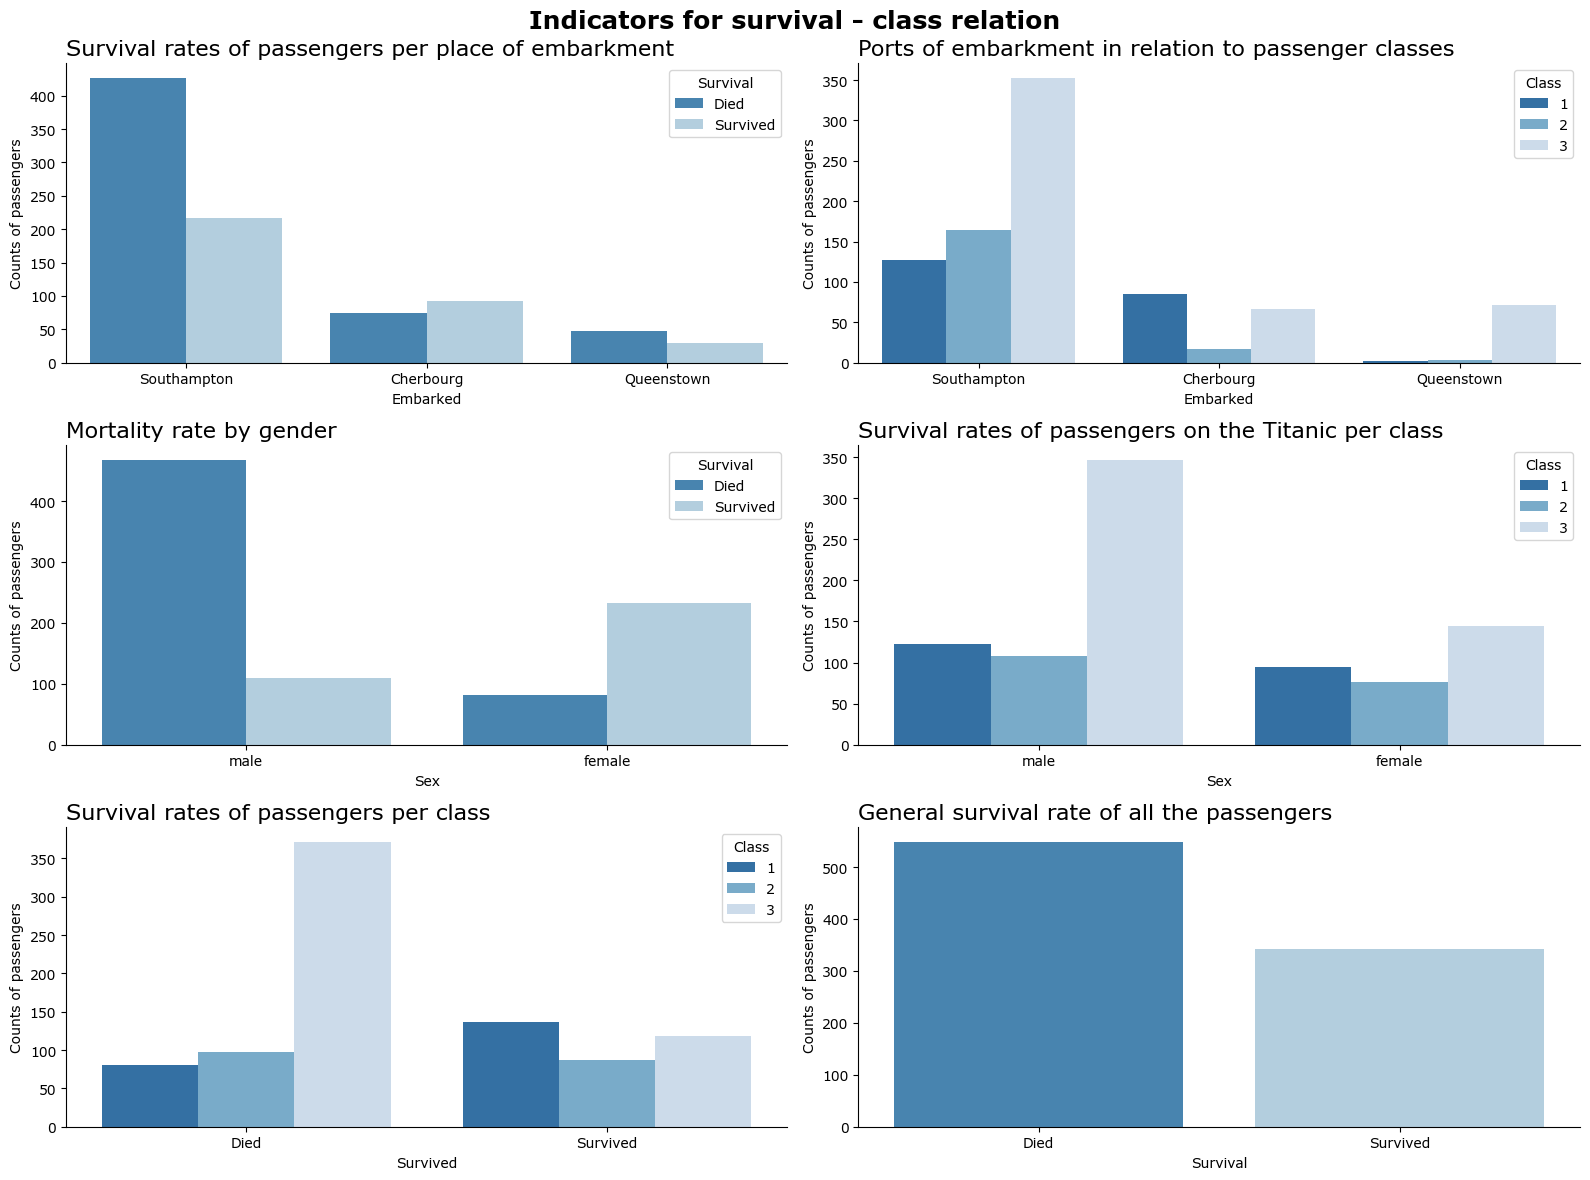

In [224]:
# Create a figure with two subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
plt.rcParams['font.family'] = "Verdana"

fig.suptitle("Indicators for survival - class relation", fontsize=18, fontweight="bold")

# First subplot - Survival rates
plt.sca(axes[0, 0])
plt.title("Survival rates of passengers per place of embarkment", loc="left", font="Verdana", fontsize=16)
ax1 = sns.countplot(x='Embarked', data=t_df_dropped, hue="Survived", palette="Blues_r")
ax1.set_ylabel("Counts of passengers")
ax1.set_xticklabels(["Southampton", "Cherbourg", "Queenstown"])
ax1.legend(title="Survival",labels=["Died", "Survived"])
sns.despine(left=False, bottom=False)

# Second subplot - Passenger classes
plt.sca(axes[0, 1])
plt.title("Ports of embarkment in relation to passenger classes", loc="left", font="Verdana", fontsize=16)
ax2 = sns.countplot(x='Embarked', data=t_df_dropped, hue="Pclass", palette="Blues_r")
ax2.set_ylabel("Counts of passengers")
ax2.set_xticklabels(["Southampton", "Cherbourg", "Queenstown"])
ax2.legend(title="Class")
sns.despine(left=False, bottom=False)

# Third subplot - Passenger genders
plt.sca(axes[1, 0])
plt.title("Mortality rate by gender", loc="left", font="Verdana", fontsize=16)
ax3 = sns.countplot(x='Sex',data=t_df_dropped, hue="Survived", palette="Blues_r")
ax3.set_ylabel("Counts of passengers")
ax3.legend(title="Survival",labels=["Died", "Survived"])
sns.despine(left=False, bottom=False)

# Fourth subplot - Passenger gender per class
plt.sca(axes[1, 1])
plt.title("Survival rates of passengers on the Titanic per class", loc="left", font="Verdana", fontsize=16)
ax4 = sns.countplot(x='Sex', data=t_df_dropped, hue="Pclass", palette="Blues_r")
ax4.set_ylabel("Counts of passengers")
ax4.legend(title="Class")
sns.despine(left=False, bottom=False)

# Fifth subplot - Passenger survival rate by class
plt.sca(axes[2, 0])
plt.title("Survival rates of passengers per class", loc="left", font="Verdana", fontsize=16)
ax5 = sns.countplot(x='Survived', data=t_df_dropped, hue="Pclass", palette="Blues_r")
ax5.set_ylabel("Counts of passengers")
ax5.set_xticklabels(["Died", "Survived"])
ax5.legend(title="Class")
sns.despine(left=False, bottom=False)

# Sixth subplot - General passenger survival rate
plt.sca(axes[2, 1])
plt.title("General survival rate of all the passengers", loc="left", font="Verdana", fontsize=16)
ax6 = sns.countplot(x='Survived', data=t_df_dropped, palette="Blues_r")
ax6.set_ylabel("Counts of passengers")
ax6.set_xlabel("Survival")
ax6.set_xticklabels(["Died", "Survived"])
sns.despine(left=False, bottom=False)

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

In [225]:
# Calculate the total number of passengers
total_passengers = len(t_df_dropped)
not_survived_count = len(t_df_dropped[t_df_dropped['Survived'] == 0])
overall_mortality_rate = not_survived_count / total_passengers
print("Overall Mortality Rate:", overall_mortality_rate)

# First, let's calculate the total number of passengers in each class
class_counts = t_df_dropped['Pclass'].value_counts().sort_index()
not_survived_counts = t_df_dropped[t_df_dropped['Survived'] == 0]['Pclass'].value_counts().sort_index()
mortality_rate = not_survived_counts / class_counts
print("Mortality Rate by", mortality_rate)

Overall Mortality Rate: 0.6161616161616161
Mortality Rate by Pclass
1    0.370370
2    0.527174
3    0.757637
Name: count, dtype: float64


Upon examining the graphs, it may initially appear that the port of embarkation and gender have a significant impact on survivability. However, a deeper analysis reveals that these factors are proxies for a more influential predictor: passenger class.

For instance, passengers embarking from Southampton had a higher likelihood of not surviving compared to those from other ports. This observation becomes more enlightening when considering the composition of Southampton passengers, who were predominantly third-class travelers.

Similarly, the data suggests that the mortality rate among men is higher than that among women. Once again, this can be elucidated by examining the passenger composition. Males were notably more likely to belong to the third-class category.

In a broader context, third-class passengers exhibited a mortality rate of 75.7%, while first-class passengers had a substantially lower rate of 37.0%. These figures significantly deviate from the overall mortality rate for all passengers, which stands at 61.6%.